CLEAN NOTEBOOK (Colab) — Latvian Leaflets Topic Modeling Pipeline

What you get (in this order):
1) TF–IDF + NMF (fixed N_TOPICS=6)
2) NMF original histogram (topics 0..5)
3) NMF aggregated histogram (6 labels via dict)
4) Shared UMAP map for NMF (same UMAP used everywhere)
5) BERTopic (arbitrary number of topics)
6) BERTopic original histogram (many topics + outliers)
7) BERTopic aggregated histogram (6 labels via mapping dict)
8) Shared UMAP map for BERTopic (same UMAP)
9) Manual CSV (id, manual_topic) → histogram by year (years from ZIP filenames)
10) Compare NMF vs manual (accuracy + crosstab)
11) Compare BERTopic vs manual (accuracy + crosstab)

IMPORTANT YOU MUST EDIT:
- NMF_TOPIC_LABELS (mapping 0..5 -> your 6 blocks)
- BT_TO_BLOCK (mapping BERTopic topic IDs -> your 6 blocks)

In [1]:
#@title 0) Install deps (run once)
!pip install -q scikit-learn sentence-transformers umap-learn bertopic==0.16.0 hdbscan

In [2]:
#@title 1) Upload ZIP and extract TXT files
import os, re, zipfile, io
import pandas as pd
from google.colab import files
from IPython.display import display

print("Upload ZIP (with .txt leaflets):")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No ZIP uploaded.")

zip_name = next(iter(uploaded.keys()))
if not zip_name.lower().endswith(".zip"):
    raise SystemExit("Please upload a .zip archive.")

extract_dir = "leaflets_zip"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), "r") as zf:
    zf.extractall(extract_dir)

files_list = sorted([
    os.path.join(extract_dir, f)
    for f in os.listdir(extract_dir)
    if f.lower().endswith(".txt")
])

print(f"Extracted {len(files_list)} TXT files → {extract_dir}")
if not files_list:
    raise SystemExit("ZIP contained no .txt files.")

Upload ZIP (with .txt leaflets):


Saving latvian_communist_leaflets_1934-1936.zip to latvian_communist_leaflets_1934-1936.zip
Extracted 201 TXT files → leaflets_zip


In [3]:
#@title 2) Parse corpus + minimal Latvian cleaning + year/id extraction
import re

LATVIAN_STOPWORDS = set('''
un par lai kas bet arī kā tas tādas tādi tādas tās šis šie šīs bija būs bez pie pret vai kad tad tik ar no uz
mēs jūs viņi viņas viņš viņa kuri kuras kuru kādu kādas kādi kāds viss visi visas jo vai nu gan drīz vien vēl jau
pat kāpēc kurp ne nav tiek tiekam tikt tika vairāk mazāk ļoti tikai nekā taču
'''.split())

META_STOP = {"id","file_name","title","author","date","print_run","typography_name","source","text","revl"}
STOPWORDS = LATVIAN_STOPWORDS | META_STOP

meta_re1 = re.compile(r"\ntext:\s*", flags=re.IGNORECASE)
meta_re2 = re.compile(r"\ntext\n", flags=re.IGNORECASE)

def extract_year(fn: str):
    m = re.search(r'19(3[4-9]|40)', str(fn))
    return int(m.group(0)) if m else None

def extract_doc_id(fn: str):
    fn = str(fn)
    m = re.search(r"revl-n(\d+)([a-z])?", fn, flags=re.IGNORECASE)
    if not m:
        m = re.search(r"\bn(\d+)([a-z])?\b", fn, flags=re.IGNORECASE)
    if not m:
        return None
    return str(int(m.group(1))) + (m.group(2) or "")

rows = []
for path in files_list:
    with open(path, "r", encoding="utf-8", errors="replace") as fh:
        raw = fh.read()

    parts = meta_re1.split(raw, maxsplit=1)
    if len(parts) == 2:
        body = parts[1]
    else:
        parts2 = meta_re2.split(raw, maxsplit=1)
        body = parts2[1] if len(parts2) == 2 else raw

    t = body.lower()
    t = re.sub(r"\b\d{2,}\b", " ", t)  # remove 2+ digit numbers
    t = re.sub(r"[^\w\s\-\ā\č\ē\ģ\ī\ķ\ļ\ņ\ŗ\š\ū\ž]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()

    tokens = [w for w in t.split() if len(w) > 2 and w not in STOPWORDS]
    clean = " ".join(tokens)

    fn = os.path.basename(path)
    rows.append({
        "file_name": fn,
        "raw": raw,
        "text": body.strip(),
        "clean": clean,
        "year": extract_year(fn),
        "doc_id": extract_doc_id(fn),
    })

df = pd.DataFrame(rows)
print("Docs:", len(df))
display(df[["file_name","doc_id","year","clean"]].head(3))

if df["doc_id"].isna().any():
    print("WARNING: Some doc_id could not be extracted. Check filename patterns.")
    display(df[df["doc_id"].isna()][["file_name"]].head(20))

Docs: 201


,file_name,doc_id,year,clean
0,revl-n001-LKP_LKJS_Vidienas_org-5000-[1934-01-...,1,1934,cīņas uzvaras vienotā revolucionārā frontē dar...
1,revl-n002-LKP_soldiers_org-1500-[1934-01-11…].txt,2,1934,cīņas uzvaras visu zemju proletārieši savienoj...
2,revl-n003-SP_CK-unk-[…1934-01-21].txt,3,1934,visu zemju proletārieši savienojieties biedri ...


In [4]:
#@title 3) Shared embeddings + SHARED UMAP(2D) coords for ALL maps (NMF/BERTopic/Manual)
import numpy as np
from sentence_transformers import SentenceTransformer
from umap import UMAP

# One encoder for all visual maps
emb_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

texts_for_embed = df["clean"].tolist()
embeddings = emb_model.encode(
    texts_for_embed,
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True
)

# One UMAP fit (2D) — used only for visualization (shared for NMF/BERTopic/Manual)
umap_vis = UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

coords_umap = umap_vis.fit_transform(embeddings)
df["umap_x"] = coords_umap[:, 0]
df["umap_y"] = coords_umap[:, 1]

print("Shared UMAP coords ready:", coords_umap.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shared UMAP coords ready: (201, 2)


In [5]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

YEAR_MARKERS = {
    1934: 'o', 1935: '^', 1936: 's', 1937: 'D', 1938: 'P', 1939: 'X', 1940: '*',
    None: 'x'   # если год не извлечён
}

BLOCK_PALETTE = {
    "Labour":      "#1f77b4",
    "Aid":         "#2ca02c",
    "Youth":       "#9467bd",
    "Women":       "#d62728",
    "Foreign/War": "#ff7f0e",
    "Spain":       "#8c564b",
    "Other":       "#7f7f7f",
    "Outlier":     "#cccccc",
}

BLOCK_ORDER = ["Labour","Aid","Youth","Women","Foreign/War","Spain","Other","Outlier"]

def plot_counts_bar(series, title, xlabel="Topic", ylabel="Count", rotate_xticks=0):
    vc = series.value_counts(dropna=False)
    plt.figure(figsize=(9,5))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotate_xticks)
    plt.show()

def plot_shares_by_year(df, label_col, title, palette=BLOCK_PALETTE, order=BLOCK_ORDER):
    tmp = df.dropna(subset=["year"]).copy()
    tmp[label_col] = tmp[label_col].fillna("Outlier")

    tab = tmp.pivot_table(index="year", columns=label_col, values="file_name",
                          aggfunc="count", fill_value=0)
    tab_pct = tab.div(tab.sum(axis=1), axis=0)
    tab_pct = tab_pct.reindex(columns=order, fill_value=0)

    ax = tab_pct.plot(kind="bar", stacked=True, figsize=(9,6),
                      color=[palette[c] for c in tab_pct.columns])
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Share")
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Block")
    plt.show()

def plot_shared_umap(df, label_col, title, palette=BLOCK_PALETTE, order=BLOCK_ORDER):
    x = df["umap_x"].values
    y = df["umap_y"].values
    labels = df[label_col].fillna("Outlier")
    years = df["year"]

    fig, ax = plt.subplots(figsize=(10,7))

    for blk in order:
        if blk not in palette:
            continue
        mask_blk = (labels == blk).values
        if not mask_blk.any():
            continue
        for yr, marker in YEAR_MARKERS.items():
            mask = mask_blk & (years == yr)
            if not mask.any():
                continue
            ax.scatter(
                x[mask], y[mask],
                c=palette[blk], s=65, marker=marker,
                edgecolors="k", linewidths=0.25
            )

    ax.set_title(title)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

    counts = labels.value_counts()
    block_handles = []
    for blk in order:
        n = int(counts.get(blk, 0))
        if n == 0:
            continue
        block_handles.append(mpatches.Patch(color=palette.get(blk, "#7f7f7f"), label=f"{blk} (n={n})"))

    year_handles = []
    for yr, marker in YEAR_MARKERS.items():
        if yr is not None and not (years == yr).any():
            continue
        if yr is None and not years.isna().any():
            continue
        year_handles.append(Line2D([0],[0], marker=marker, linestyle="None", color="k",
                                   label=str(yr), markersize=7))

    plt.subplots_adjust(right=0.80)
    side_ax = fig.add_axes([0.82, 0.10, 0.16, 0.80])
    side_ax.axis("off")
    leg1 = side_ax.legend(handles=block_handles, title="Blocks",
                          loc="upper left", bbox_to_anchor=(0.0, 1.0),
                          frameon=True, fontsize=9, title_fontsize=10)
    side_ax.add_artist(leg1)
    _ = side_ax.legend(handles=year_handles, title="Year",
                       loc="upper left", bbox_to_anchor=(0.0, 0.35),
                       frameon=True, fontsize=9, title_fontsize=10)

    plt.show()


In [6]:
#@title 5) Upload MANUAL CSV (id, manual_topic) and merge (years already from ZIP)
import numpy as np

CSV_NAME = "manual_annotation_topics_2_columns.csv"  # <- your CSV must have columns: id, manual_topic
print(f"Upload manual CSV named exactly: {CSV_NAME}")
uploaded = files.upload()
if CSV_NAME not in uploaded:
    raise SystemExit(f"Upload file named exactly: {CSV_NAME}")

manual_df = pd.read_csv(CSV_NAME, dtype=str)
manual_df.columns = manual_df.columns.str.strip()

expected = {"id", "manual_topic"}
if not expected.issubset(set(manual_df.columns)):
    raise ValueError(f"CSV must contain columns: {expected}. Found: {list(manual_df.columns)}")

manual_df["id"] = manual_df["id"].astype(str).str.strip()
manual_df["manual_topic"] = manual_df["manual_topic"].astype(str).str.strip()

df = df.merge(manual_df.rename(columns={"id": "doc_id"}), on="doc_id", how="left")

missing = df["manual_topic"].isna().sum()
print("Manual rows:", len(manual_df))
print("Docs in df:", len(df))
print("Missing manual_topic after merge:", int(missing))
if missing:
    display(df[df["manual_topic"].isna()][["doc_id","file_name"]].head(30))

# normalize manual block column for plots
df["manual_block"] = df["manual_topic"].fillna("Outlier")

Upload manual CSV named exactly: manual_annotation_topics_2_columns.csv


Saving manual_annotation_topics_2_columns.csv to manual_annotation_topics_2_columns.csv
Manual rows: 266
Docs in df: 201
Missing manual_topic after merge: 0


In [7]:
#@title 6) TF–IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.95)
X = vectorizer.fit_transform(df["clean"].values)
feature_names = vectorizer.get_feature_names_out()
print("TF–IDF shape:", X.shape)

TF–IDF shape: (201, 7928)



=== BERTopic topics ===

Topic 0 (n=11):
  algas, strādniekus, rīgas, biedri, strādniekiem, mūsu, prasības, algu, mums, streikā

Topic 1 (n=11):
  īres, strādniecības, valdības, komunistu, tie, strādniekus, lkp, pilsētu, rīgas pilsētas, pretfašisma cīņas

Topic 2 (n=10):
  padomju, oktobra, sprs, krievijas, revolūcijas, darbaļaužu, darbaļaudis, oktobra revolūcijas, darbaļaudīm, proletariāta

Topic 3 (n=9):
  sprs, pasaules, jaunatnes, jauna, padomju, karā, karu, pretkara, savienības, fašismu

Topic 4 (n=7):
  arodbiedrību, darba tautas, svētki, fašistiskā valdība, tautas, strādniekiem, fašisms, fašistiskā, sprs, pretfašistu

Topic 5 (n=7):
  skolu, skolnieku, skolas, skolās, skolā, jaunatnes, jauniešiem, skola, pilsētas, skolām

Topic 6 (n=7):
  sievietes, darba sievietes, mātes, sieviešu, sieviete, bērnu, daudz, sievietēm, buržuju, ģimenes

Topic 7 (n=6):
  karu, sprs, jaunatne, karš, buržuāziju, padomju, jaunatnes, karā, masu, pretkara

Topic 8 (n=6):
  skolu, padomju, kur, latgales

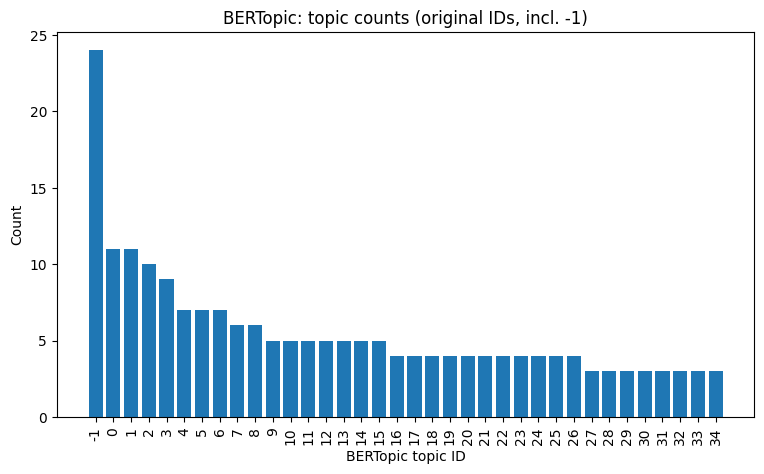

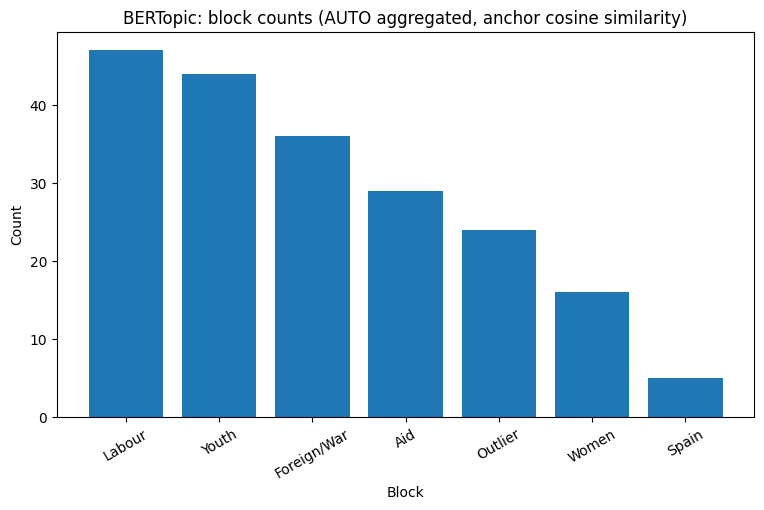

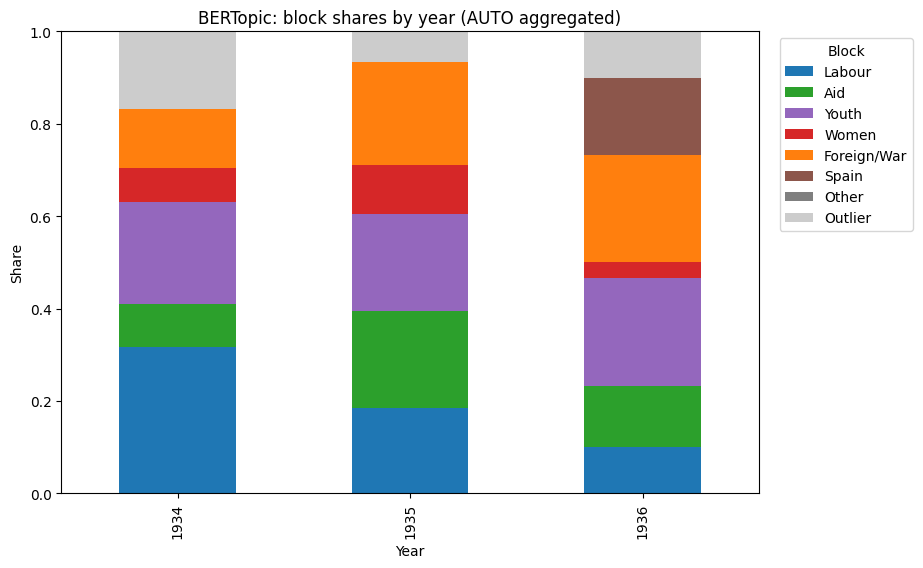

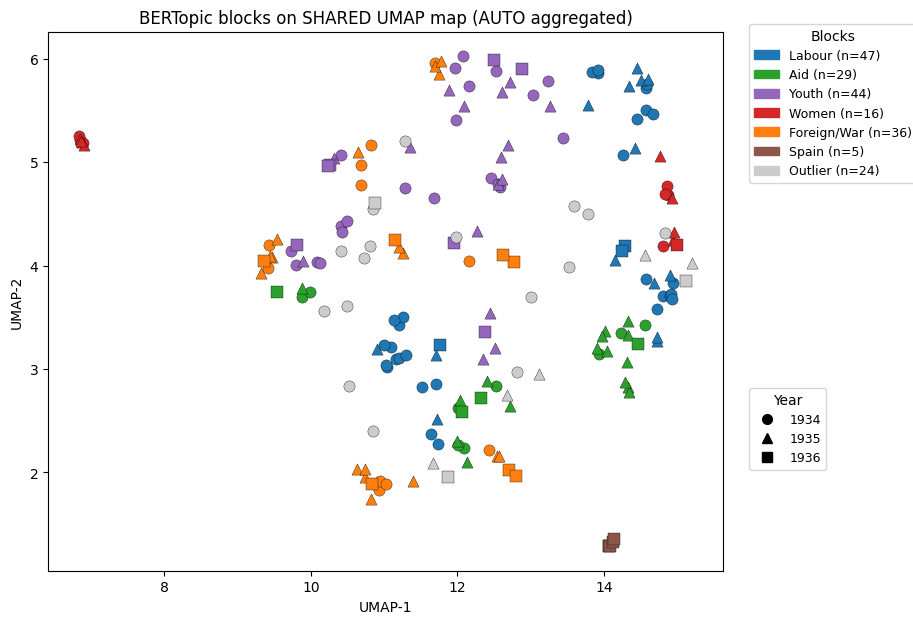

In [8]:
# --- 0) imports ---
import os, random
import numpy as np
import pandas as pd

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from hdbscan import HDBSCAN
from umap import UMAP

# --- seeds ---
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)

# --- 1) BERTopic fit (создаёт bt_topic) ---
texts_ber = df["clean"].tolist()

vectorizer_ber = CountVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.95,
    stop_words=list(STOPWORDS)
)

umap_model = UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    min_samples=1,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model = BERTopic(
    language="multilingual",
    vectorizer_model=vectorizer_ber,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics=None,
    calculate_probabilities=True
)

bt_topics, bt_probs = topic_model.fit_transform(texts_ber)

df["bt_topic"] = bt_topics
df["bt_topic_score"] = np.nan
if bt_probs is not None:
    df["bt_topic_score"] = bt_probs.max(axis=1)

# --- 2) PRINT topics ---
TOPN = 15
print("\n=== BERTopic topics ===")
for tid in sorted(t for t in df["bt_topic"].unique() if t >= 0):
    words = topic_model.get_topic(int(tid)) or []
    top_terms = [w for (w, _) in words[:TOPN]]
    n_docs = int((df["bt_topic"] == tid).sum())
    print(f"\nTopic {tid} (n={n_docs}):")
    print(" ", ", ".join(top_terms))

# --- 3) Smart block mapping: anchors + cosine similarity (+ override Spain/Women) ---
BLOCKS = ["Labour","Aid","Youth","Women","Foreign/War","Spain"]
DEFAULT_BLOCK = "Other"

BLOCK_ANCHORS = {
    "Spain": "spānijas spānijā spāņu fronte republika franko internacionāl brigāde",
    "Women": "sievietes sieviešu mātes bērnu bērni ģimenes mājsaimniecība",
    "Youth": "jaunatne jaunatnes jaunatnei jaunietis lkjs skolnieku skolu skolas skolā student",
    "Aid": "cietumos ieslodzītie politieslodzītajiem spīdzināšana spīdzin bendes protests politpārvalde murina ventspils",
    "Labour": "strādnieku strādniekiem algas algu streikā arodbiedrību bezdarbnieku darba nespējas īres ierēdņi pašvaldību darbinieku",
    "Foreign/War": "karš karu pretkara fašisms fašistiskā pretfašistu hitler vācu vācija imperiālisms miera psrs sprs oktobra revolūcija abesīnija"
}

def override_block(words_joined: str):
    if "spān" in words_joined:
        return "Spain", "OVERRIDE"
    if any(x in words_joined for x in ["siev", "māt", "bērn", "ģimen"]):
        return "Women", "OVERRIDE"
    return None, None

def topic_as_weighted_text(tid, topn=30):
    pairs = topic_model.get_topic(int(tid)) or []
    pairs = pairs[:topn]
    tokens = []
    for term, w in pairs:
        rep = 1
        if w >= 0.05: rep = 2
        if w >= 0.10: rep = 3
        tokens.extend([term] * rep)
    return " ".join(tokens)

def build_block_classifier(topic_ids, topn_topic_terms=30):
    docs = []
    # anchors first
    for b in BLOCKS:
        docs.append(BLOCK_ANCHORS[b])
    # topics
    for tid in topic_ids:
        docs.append(topic_as_weighted_text(tid, topn=topn_topic_terms))

    vec = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=1)
    X = vec.fit_transform(docs)
    X_anchors = X[:len(BLOCKS)]
    X_topics = X[len(BLOCKS):]
    return X_anchors, X_topics

topic_ids = sorted(t for t in df["bt_topic"].unique() if t >= 0)
X_anchors, X_topics = build_block_classifier(topic_ids, topn_topic_terms=30)

bt_to_block_auto = {}
print("\n=== AUTO BERTopic topic -> block mapping (anchor cosine similarity) ===")

for i, tid in enumerate(topic_ids):
    top_words = [w for (w, _) in (topic_model.get_topic(int(tid)) or [])[:15]]
    joined = " ".join(top_words)

    oblk, rule = override_block(joined)
    if oblk is not None:
        bt_to_block_auto[int(tid)] = oblk
        print(f"\nTopic {tid}: {oblk}  [{rule}]")
        print("  top words:", ", ".join(top_words[:12]))
        continue

    sims = cosine_similarity(X_topics[i], X_anchors)[0]
    best_idx = int(np.argmax(sims))
    best_blk = BLOCKS[best_idx]
    bt_to_block_auto[int(tid)] = best_blk

    sim_dict = {BLOCKS[j]: float(sims[j]) for j in range(len(BLOCKS))}
    sim_sorted = dict(sorted(sim_dict.items(), key=lambda x: x[1], reverse=True))

    print(f"\nTopic {tid}: {best_blk}  [COSINE]")
    print("  sims:", sim_sorted)
    print("  top words:", ", ".join(top_words[:12]))

def map_bt_block(tid):
    if tid < 0:
        return "Outlier"
    return bt_to_block_auto.get(int(tid), DEFAULT_BLOCK)

df["bt_block"] = df["bt_topic"].apply(map_bt_block)

# --- 4) plots ---
plot_counts_bar(
    df["bt_topic"],
    "BERTopic: topic counts (original IDs, incl. -1)",
    xlabel="BERTopic topic ID",
    rotate_xticks=90
)

plot_counts_bar(
    df["bt_block"],
    "BERTopic: block counts (AUTO aggregated, anchor cosine similarity)",
    xlabel="Block",
    rotate_xticks=30
)

plot_shares_by_year(df, "bt_block", "BERTopic: block shares by year (AUTO aggregated)")

# shared UMAP: если у тебя уже есть df['umap_x','umap_y'] — будет использовано.
# если нет — делаем из UMAP-embeddings BERTopic (они есть внутри topic_model)
if not {"umap_x","umap_y"}.issubset(df.columns):
    # topic_model.umap_model_ хранит fitted UMAP, а topic_model.embedding_ может быть None в некоторых версиях
    # стабильнее: берём topic_model.umap_model.transform(topic_model._extract_embeddings(...)) сложно,
    # поэтому используем уже рассчитанные topic_model.umap_model_ на topic_model._reduce_dimensionality output недоступно.
    # Практический вариант: используем BERTopic-projected coordinates, если они есть:
    try:
        coords = topic_model.umap_model.embedding_
        if coords is not None and len(coords) == len(df):
            df["umap_x"] = coords[:, 0]
            df["umap_y"] = coords[:, 1]
    except Exception:
        pass

plot_shared_umap(df, "bt_block", "BERTopic blocks on SHARED UMAP map (AUTO aggregated)")



=== NMF topics (top words) ===

Topic 0 (n=36):
  sprs, kara, latvijas, padomju, darbaļaužu, tautu, karu, tautas, vācijas, pasaules, vācu, ulmaņa, baltijas, miera, visu

Topic 1 (n=81):
  strādnieku, darba, algas, strādnieki, strādniekiem, arodbiedrību, biedri, valdība, algu, strādniekus, bezdarbnieku, arodbiedrības, mūsu, cīņas, lauku

Topic 2 (n=38):
  latvijas, darba, palīdzības, fašistu, sarkanās palīdzības, darba tautas, sarkanās, cietumos, tautas, nāves, politieslodzītajiem, protesta, strādnieku, politieslodzīto, latvijas sarkanās

Topic 3 (n=7):
  sievietes, darba sievietes, mātes, sieviešu, darba, sievietes mātes, bērnu, daudz, ģimenes, sievietēm, sieviete, buržuju, vienādu, martā, darba sieviete

Topic 4 (n=31):
  jaunatnes, darba, jaunatne, jaunatnei, skolu, strādnieku, latvijas, jaunatni, darba jaunatnes, skolnieku, skolas, cīņas, jaunieši, tautas, cīņā

Topic 5 (n=8):
  spānijas, spāņu, tautas, spānijā, brīvības, spāņu tautas, savu, cīnītāju, latvijas, tauta, spānijas brīv

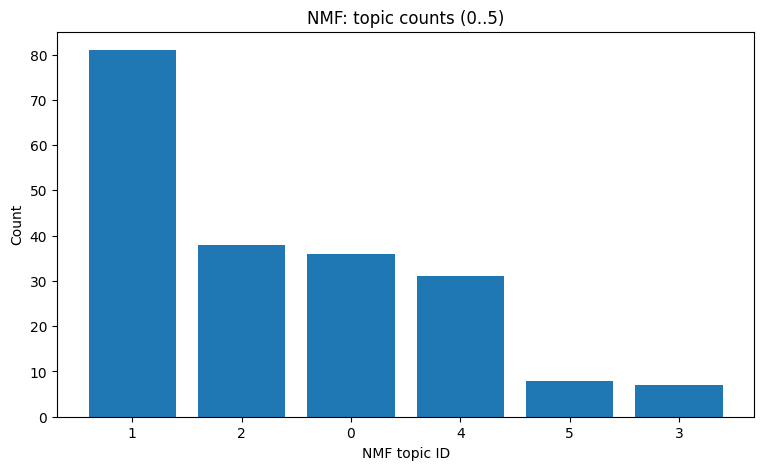

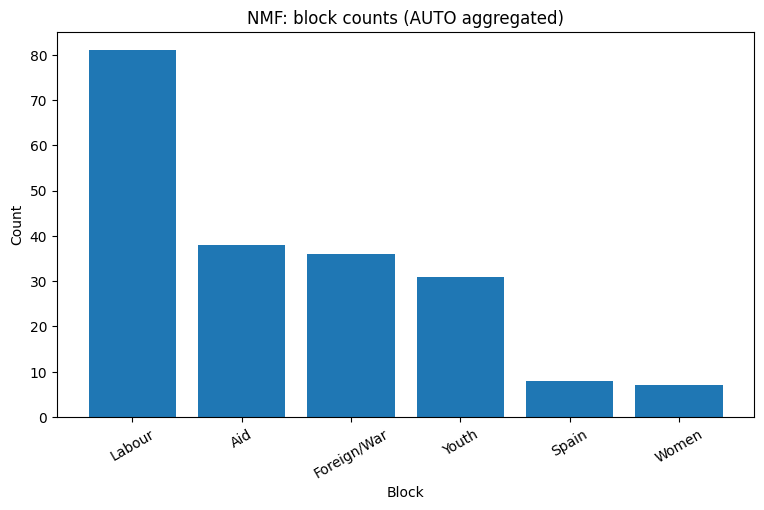

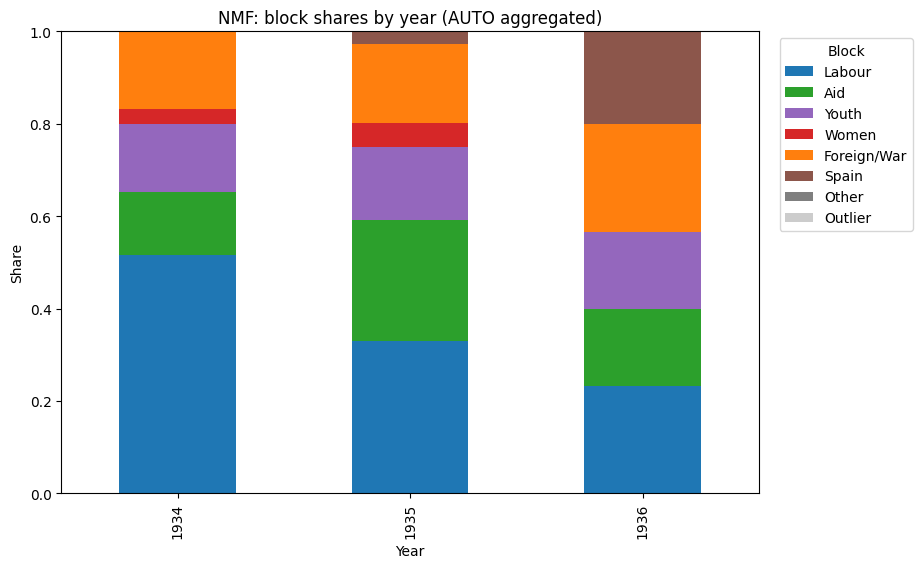

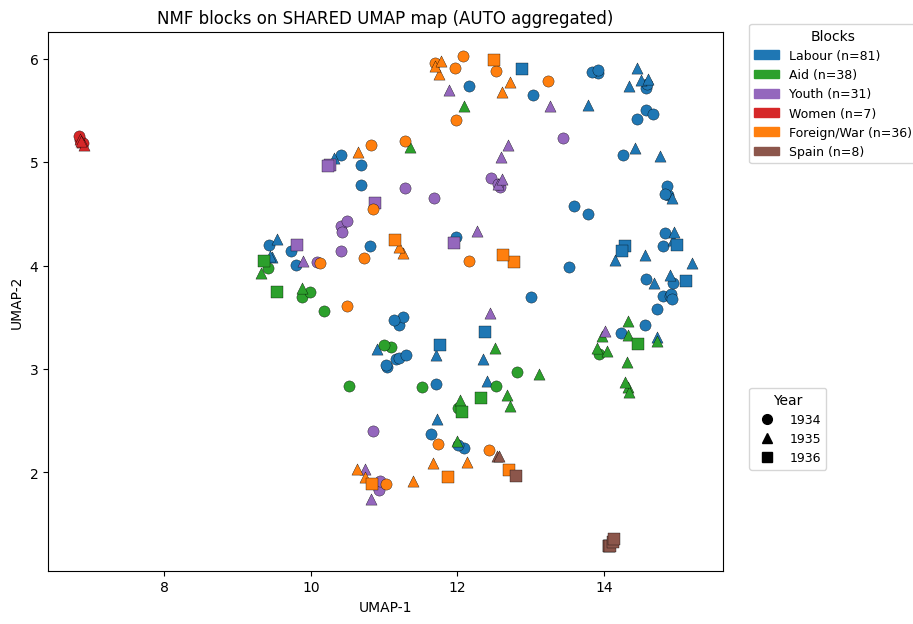

In [9]:
#@title 7) TF–IDF -> NMF + AUTO 6-block mapping + plots (creates H, W, nmf_topic, nmf_block)
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- sanity: need TF-IDF matrix ---
if "X" not in globals() or "feature_names" not in globals():
    raise NameError("Missing X/feature_names. Run the TF–IDF vectorization cell first.")

# ---------------------------
# 1) NMF fit (создаёт W и H)
# ---------------------------
N_TOPICS = 6
nmf = NMF(
    n_components=N_TOPICS,
    random_state=42,
    init="nndsvda",
    max_iter=600
)
W = nmf.fit_transform(X)     # doc-topic
H = nmf.components_          # topic-term

df["nmf_topic"] = W.argmax(axis=1)
df["nmf_topic_score"] = W.max(axis=1)

# ---------------------------
# 2) Print NMF topics (top words) + сохранить nmf_topics_words
# ---------------------------
TOPN = 15
nmf_topics_words = {}
print("\n=== NMF topics (top words) ===")
for k in range(N_TOPICS):
    row = H[k]
    top_idx = np.argsort(row)[::-1][:TOPN]
    top_terms = [feature_names[i] for i in top_idx]
    nmf_topics_words[k] = top_terms
    n_docs = int((df["nmf_topic"] == k).sum())
    print(f"\nTopic {k} (n={n_docs}):")
    print(" ", ", ".join(top_terms))

# ---------------------------
# 3) AUTO aggregation to 6 blocks (anchors + cosine, как у BERTopic)
# ---------------------------
BLOCKS = ["Labour","Aid","Youth","Women","Foreign/War","Spain"]
DEFAULT_BLOCK = "Other"

BLOCK_ANCHORS = {
    "Spain": "spānijas spānijā spāņu fronte republika franko internacionāl brigāde",
    "Women": "sievietes sieviešu mātes bērnu bērni ģimenes mājsaimniecība",
    "Youth": "jaunatne jaunatnes jaunatnei jaunietis lkjs skolnieku skolu skolas skolā student pionier",
    "Aid": "cietumos ieslodzītie politieslodzītajiem spīdzināšana spīdzin bendes protests politpārvalde murina ventspils",
    "Labour": "strādnieku strādniekiem algas algu streikā arodbiedrību bezdarbnieku īres ierēdņi pašvaldību darbinieku",
    "Foreign/War": "karš karu pretkara fašisms fašistiskā pretfašistu hitler vācu vācija imperiālisms miera psrs sprs oktobra revolūcija abesīnija"
}

def override_block_from_words(words_joined: str):
    if "spān" in words_joined:
        return "Spain", "OVERRIDE"
    if any(x in words_joined for x in ["siev", "māt", "bērn", "ģimen"]):
        return "Women", "OVERRIDE"
    return None, None

def nmf_topic_as_weighted_text(topic_id: int, topn=40):
    row = H[topic_id]
    top_idx = np.argsort(row)[::-1][:topn]
    top_weights = row[top_idx]
    p60 = np.percentile(top_weights, 60)
    p80 = np.percentile(top_weights, 80)
    p95 = np.percentile(top_weights, 95)

    tokens = []
    for j in top_idx:
        term = feature_names[j]
        w = row[j]
        rep = 1
        if w >= p95: rep = 4
        elif w >= p80: rep = 3
        elif w >= p60: rep = 2
        tokens.extend([term] * rep)
    return " ".join(tokens)

topic_ids = list(range(N_TOPICS))
docs = [BLOCK_ANCHORS[b] for b in BLOCKS] + [nmf_topic_as_weighted_text(t, topn=40) for t in topic_ids]

vec = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=1)
X_all = vec.fit_transform(docs)
X_anchors = X_all[:len(BLOCKS)]
X_topics = X_all[len(BLOCKS):]

nmf_to_block_auto = {}
print("\n=== AUTO NMF topic -> block mapping (anchor cosine similarity) ===")

for i, tid in enumerate(topic_ids):
    top_words = nmf_topics_words.get(tid, [])
    joined = " ".join(top_words)

    oblk, rule = override_block_from_words(joined)
    if oblk is not None:
        nmf_to_block_auto[tid] = oblk
        print(f"\nTopic {tid}: {oblk}  [{rule}]")
        print("  top words:", ", ".join(top_words[:12]))
        continue

    sims = cosine_similarity(X_topics[i], X_anchors)[0]
    best_idx = int(np.argmax(sims))
    best_blk = BLOCKS[best_idx]
    nmf_to_block_auto[tid] = best_blk

    sim_sorted = dict(sorted(
        {BLOCKS[j]: float(sims[j]) for j in range(len(BLOCKS))}.items(),
        key=lambda x: x[1], reverse=True
    ))
    print(f"\nTopic {tid}: {best_blk}  [COSINE]")
    print("  sims:", sim_sorted)
    print("  top words:", ", ".join(top_words[:12]))

df["nmf_block"] = df["nmf_topic"].apply(lambda t: nmf_to_block_auto.get(int(t), DEFAULT_BLOCK))

# ---------------------------
# 4) plots (гистограммы + UMAP как раньше)
# ---------------------------
plot_counts_bar(df["nmf_topic"], "NMF: topic counts (0..5)", xlabel="NMF topic ID", rotate_xticks=0)
plot_counts_bar(df["nmf_block"], "NMF: block counts (AUTO aggregated)", xlabel="Block", rotate_xticks=30)
plot_shares_by_year(df, "nmf_block", "NMF: block shares by year (AUTO aggregated)")
plot_shared_umap(df, "nmf_block", "NMF blocks on SHARED UMAP map (AUTO aggregated)")



=== BERTopic topics ===

Topic 0 (n=16):
  zemnieku, strādnieku zemnieku, darba tautas, viņu, palīdzības, valdība, cietumos, fašistiskā, varu, svētki

Topic 1 (n=10):
  jaunatnes, maijā, zemēs, jaunatnei, maijs, maija, jaunatne, fašisms, karogi, fašisma

Topic 2 (n=10):
  bezdarbnieku, darbu, valsts, algu, prasām, pašvaldību, organizējiet, maizi, darbu maizi, algas

Topic 3 (n=9):
  algas, rīgas, strādniekus, mūsu, biedri, uzņēmējs, īres, streikā, algu, prasības

Topic 4 (n=9):
  oktobra, sprs, krievijas, revolūcijas, oktobra revolūcijas, darbaļaužu, darbaļaudis, proletariāts, proletariāta, parīzes

Topic 5 (n=9):
  īres, strādniecības, valdības, komunistu, tie, pilsētu, pretfašisma cīņas, rīgas pilsētas, arodbiedrības, fašisma

Topic 6 (n=7):
  skolu, skolnieku, skolas, skolās, jaunatnes, skolā, jauniešiem, skola, pilsētas, skolām

Topic 7 (n=7):
  brīvības, sprs, tautai, kara stāvokļa, šķiras, kopā, lielburžuāzijas, cīņā, stāvokļa, šodien

Topic 8 (n=6):
  karu, sprs, jaunatne, karš

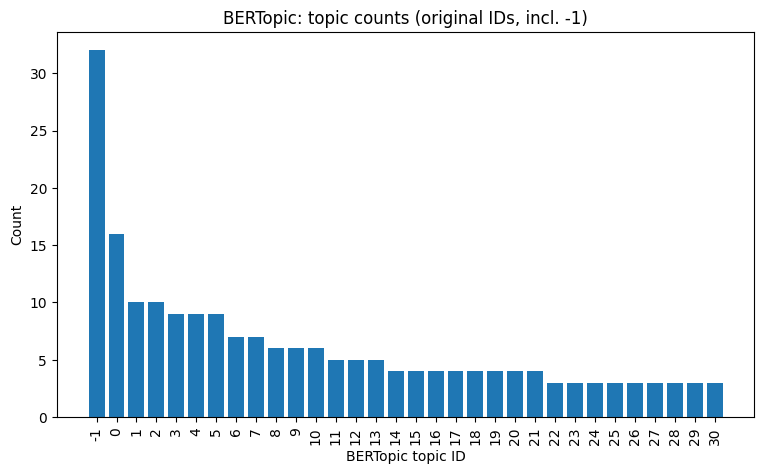

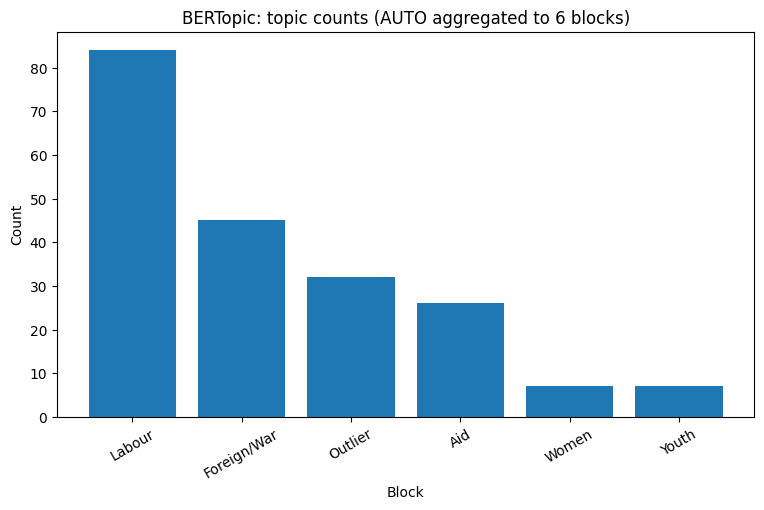

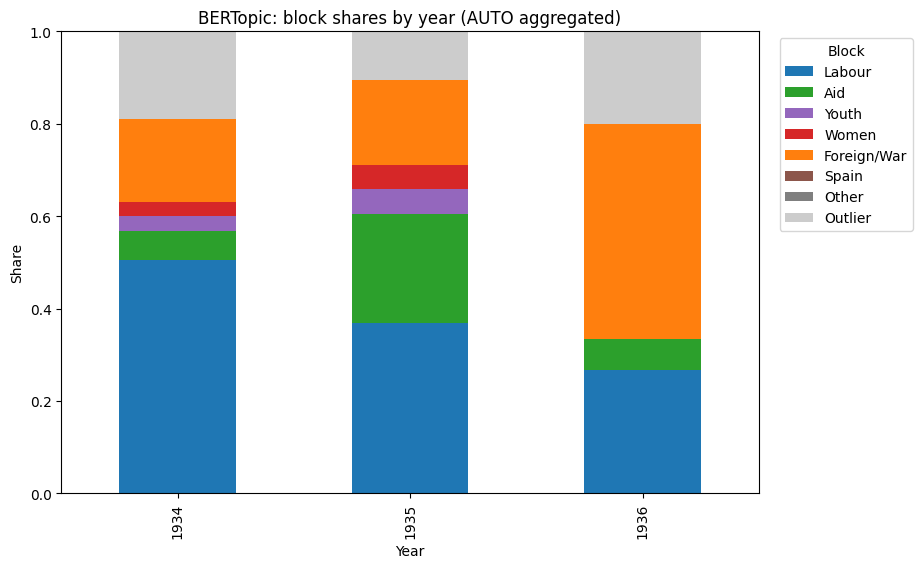

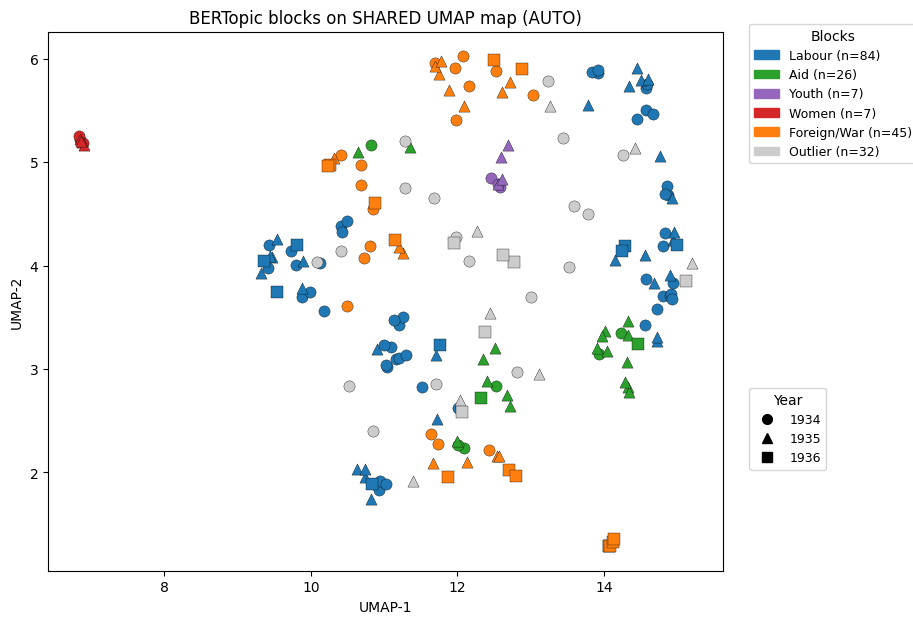

In [10]:
#@title 8) BERTopic (arbitrary number of topics) + AUTO aggregation to 6 blocks + histograms + shared UMAP
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
import numpy as np
import pandas as pd

# ---------------------------
# BERTopic fit
# ---------------------------
texts_ber = df["clean"].tolist()

vectorizer_ber = CountVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.95,
    stop_words=list(STOPWORDS)
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    min_samples=1,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model = BERTopic(
    language="multilingual",
    vectorizer_model=vectorizer_ber,
    hdbscan_model=hdbscan_model,
    nr_topics=None,
    calculate_probabilities=True
)

bt_topics, bt_probs = topic_model.fit_transform(texts_ber)

df["bt_topic"] = bt_topics
df["bt_topic_score"] = np.nan
if bt_probs is not None:
    df["bt_topic_score"] = bt_probs.max(axis=1)

# ---------------------------
# PRINT topics + top words (for sanity check)
# ---------------------------
TOPN = 15
print("\n=== BERTopic topics ===")
for tid in sorted(t for t in df["bt_topic"].unique() if t >= 0):
    words = topic_model.get_topic(int(tid)) or []
    top_terms = [w for (w, _) in words[:TOPN]]
    n_docs = int((df["bt_topic"] == tid).sum())
    print(f"\nTopic {tid} (n={n_docs}):")
    print(" ", ", ".join(top_terms))

# ---------------------------
# AUTO aggregation to 6 blocks (KEY PART)
# ---------------------------
BLOCKS = ["Labour","Aid","Youth","Women","Foreign/War","Spain"]
DEFAULT_BLOCK = "Other"

BT_BLOCK_KEYWORDS = {
    "Spain":       ["spān"],
    "Women":       ["siev", "māt", "bērn", "ģimen"],
    "Youth":       ["jaun", "skol", "pion", "student"],
    "Aid":         ["palīdz", "cietum", "ieslod", "spīdzin", "protest", "nāves", "sodu", "ties"],
    "Labour":      ["strād", "alg", "bezdarb", "aro", "streik", "darba"],
    "Foreign/War": ["kar", "vācu", "vāc", "hitler", "faš", "imper",
                    "sprs", "psrs", "padomj", "franc", "brit", "polij", "abesīn"],
}

def pick_block(words):
    joined = " ".join(words)
    scores = {b: 0 for b in BLOCKS}
    for b in BLOCKS:
        for stem in BT_BLOCK_KEYWORDS[b]:
            if stem in joined:
                scores[b] += 1
    mx = max(scores.values())
    if mx == 0:
        return DEFAULT_BLOCK
    return [b for b, s in scores.items() if s == mx][0]

bt_to_block_auto = {}
for tid in sorted(t for t in df["bt_topic"].unique() if t >= 0):
    words = [w for (w, _) in (topic_model.get_topic(int(tid)) or [])[:TOPN]]
    block = pick_block(words)
    bt_to_block_auto[int(tid)] = block
    print(f"AUTO block for Topic {tid}: {block}")

def map_bt_block(tid):
    if tid < 0:
        return "Outlier"
    return bt_to_block_auto.get(int(tid), DEFAULT_BLOCK)

df["bt_block"] = df["bt_topic"].apply(map_bt_block)

# ---------------------------
# (6) Original histogram (many topics)
# ---------------------------
plot_counts_bar(
    df["bt_topic"],
    "BERTopic: topic counts (original IDs, incl. -1)",
    xlabel="BERTopic topic ID",
    rotate_xticks=90
)

# ---------------------------
# (7) Aggregated histogram (6 blocks)
# ---------------------------
plot_counts_bar(
    df["bt_block"],
    "BERTopic: topic counts (AUTO aggregated to 6 blocks)",
    xlabel="Block",
    rotate_xticks=30
)

plot_shares_by_year(df, "bt_block", "BERTopic: block shares by year (AUTO aggregated)")

# ---------------------------
# (8) UMAP (shared)
# ---------------------------
plot_shared_umap(df, "bt_block", "BERTopic blocks on SHARED UMAP map (AUTO)")


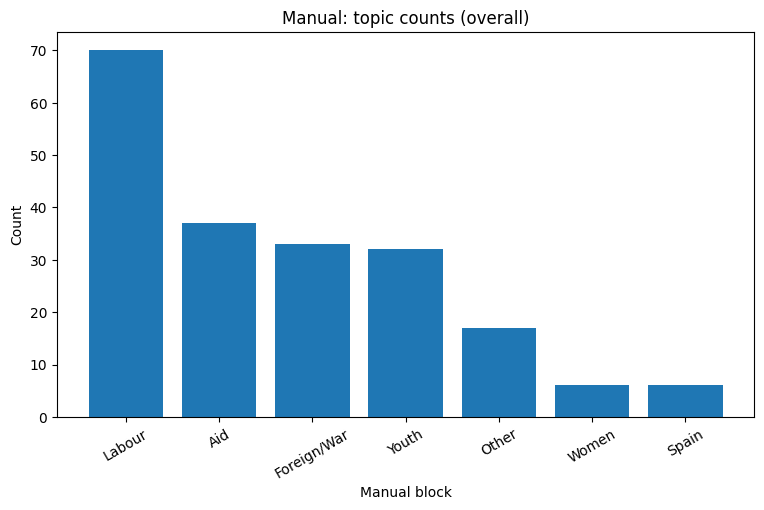

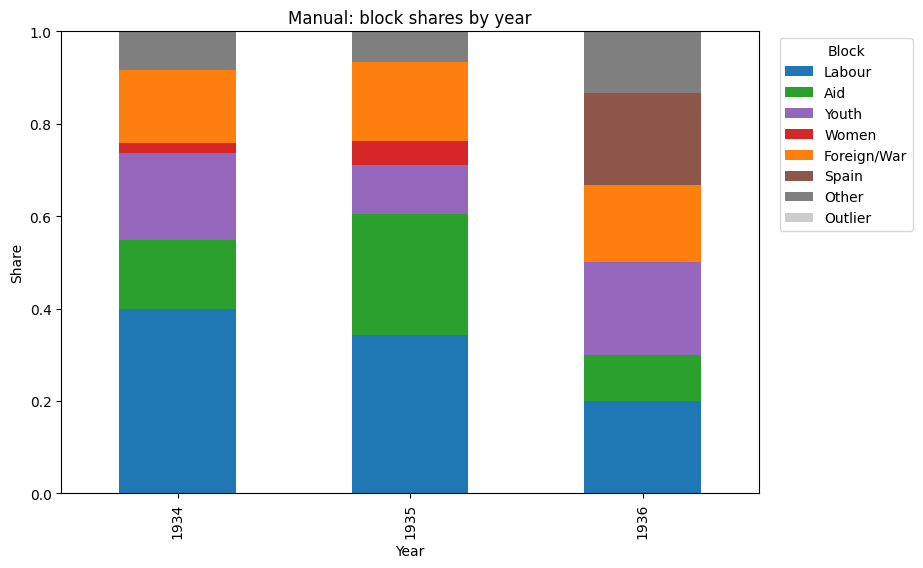

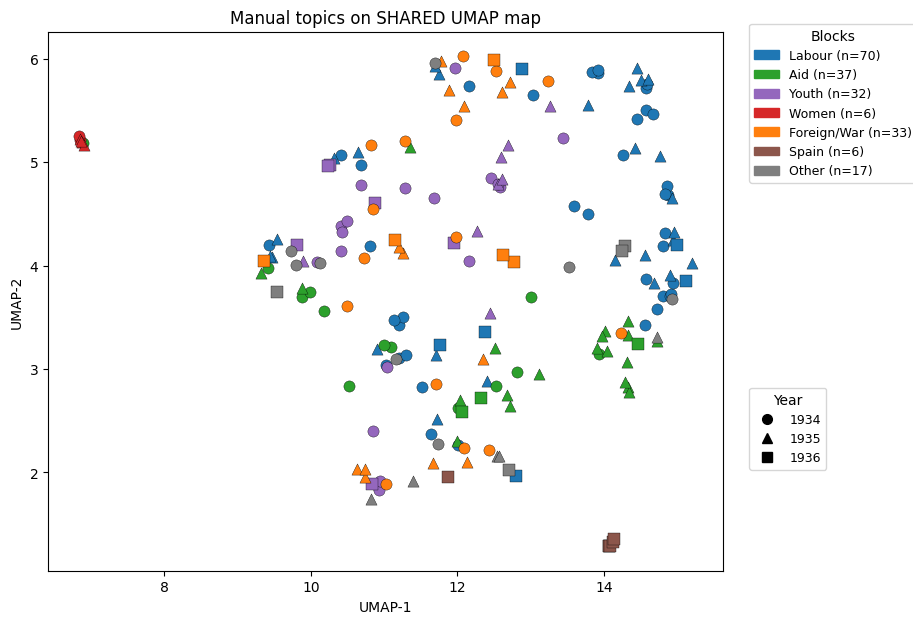

In [11]:
#@title 9) Manual histogram by year + shared UMAP
# (9) histogram (shares by year) for manual labels; years come from ZIP
plot_counts_bar(df["manual_block"], "Manual: topic counts (overall)", xlabel="Manual block", rotate_xticks=30)
plot_shares_by_year(df, "manual_block", "Manual: block shares by year")
plot_shared_umap(df, "manual_block", "Manual topics on SHARED UMAP map")

In [12]:
#@title 10) Compare NMF vs Manual (robust: auto-create nmf_block if missing)
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- sanity: manual must exist ---
if "manual_topic" not in df.columns:
    raise KeyError("df['manual_topic'] is missing. You need manual labels to evaluate accuracy.")

# --- if nmf_block missing, try to build it ---
if "nmf_block" not in df.columns:

    # Case A: you already have nmf_topic + mapping dict from previous cell
    mapping = None
    for name in ["nmf_to_block_auto", "nmf_to_block", "nmf_topic_to_block"]:
        if name in globals() and isinstance(globals()[name], dict) and len(globals()[name]) > 0:
            mapping = globals()[name]
            break

    if mapping is not None and "nmf_topic" in df.columns:
        df["nmf_block"] = df["nmf_topic"].apply(lambda t: mapping.get(int(t), "Other") if pd.notna(t) else np.nan)

    else:
        # Case B: build nmf_block via anchor cosine similarity using NMF topic top terms
        # Need: nmf_topic column + a way to get top words for each nmf topic.
        if "nmf_topic" not in df.columns:
            raise KeyError(
                "df['nmf_block'] is missing AND df['nmf_topic'] is missing. "
                "Run the NMF modeling cell first (the one that creates df['nmf_topic'])."
            )

        # Try to find topic->top_terms somewhere (common patterns)
        # Accept: nmf_topics_words (dict), nmf_top_words (dict), nmf_model + tfidf_vectorizer, etc.
        topic2words = None
        for name in ["nmf_topic_words", "nmf_topics_words", "nmf_top_words", "nmf_topic_top_terms"]:
            if name in globals() and isinstance(globals()[name], dict) and len(globals()[name]) > 0:
                topic2words = globals()[name]
                break

        if topic2words is None:
            raise KeyError(
                "df['nmf_block'] is missing. I also couldn't find a dict like "
                "nmf_topics_words/nmf_top_words with top terms per NMF topic. "
                "Export top words per topic in your NMF cell (topic_id -> list of terms), "
                "or keep nmf_to_block_auto dict from that cell."
            )

        BLOCKS = ["Labour","Aid","Youth","Women","Foreign/War","Spain"]
        DEFAULT_BLOCK = "Other"

        BLOCK_ANCHORS = {
            "Spain": "spānijas spānijā spāņu fronte republika franko internacionāl brigāde",
            "Women": "sievietes sieviešu mātes bērnu bērni ģimenes mājsaimniecība",
            "Youth": "lkjs skolnieku skolu skolas skolā student pionier jaunatne jaunietis",
            "Aid": "cietumos ieslodzītie politieslodzītajiem spīdzināšana spīdzin bendes protests politpārvalde murina ventspils",
            "Labour": "strādnieku strādniekiem algas algu streikā arodbiedrību bezdarbnieku darba nespējas īres ierēdņi pašvaldību darbinieku",
            "Foreign/War": "karš karu pretkara fašisms fašistiskā pretfašistu hitler vācu vācija imperiālisms miera psrs sprs oktobra revolūcija abesīnija"
        }

        def override(words_joined: str):
            if "spān" in words_joined:
                return "Spain"
            if any(x in words_joined for x in ["siev", "māt", "bērn", "ģimen"]):
                return "Women"
            return None

        # Build TF-IDF char ngrams on anchors + topics (as text)
        topic_ids = sorted(int(t) for t in pd.Series(df["nmf_topic"]).dropna().unique())
        docs = [BLOCK_ANCHORS[b] for b in BLOCKS]
        for tid in topic_ids:
            words = topic2words.get(tid, [])
            if isinstance(words, str):
                words = words.split()
            docs.append(" ".join(words[:30]))

        vec = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=1)
        X = vec.fit_transform(docs)
        X_anchors = X[:len(BLOCKS)]
        X_topics = X[len(BLOCKS):]

        nmf_map = {}
        for i, tid in enumerate(topic_ids):
            words = topic2words.get(tid, [])
            if isinstance(words, str):
                words = words.split()
            joined = " ".join(words[:30])

            ob = override(joined)
            if ob is not None:
                nmf_map[tid] = ob
                continue

            sims = cosine_similarity(X_topics[i], X_anchors)[0]
            nmf_map[tid] = BLOCKS[int(np.argmax(sims))]

        df["nmf_block"] = df["nmf_topic"].apply(lambda t: nmf_map.get(int(t), DEFAULT_BLOCK) if pd.notna(t) else np.nan)

# --- now evaluation (works if nmf_block exists) ---
eval_mask = df["manual_topic"].notna() & df["nmf_block"].notna()

nmf_acc = (df.loc[eval_mask, "nmf_block"] == df.loc[eval_mask, "manual_topic"]).mean()

print("NMF vs manual accuracy (exact match):", round(float(nmf_acc), 3))
print("Evaluated docs:", int(eval_mask.sum()), "/", len(df))

display(pd.crosstab(
    df.loc[eval_mask, "manual_topic"],
    df.loc[eval_mask, "nmf_block"],
    rownames=["manual"],
    colnames=["NMF"]
))


NMF vs manual accuracy (exact match): 0.801
Evaluated docs: 201 / 201


NMF,Aid,Foreign/War,Labour,Spain,Women,Youth
manual,,,,,,
Aid,34,0,1,0,1,1
Foreign/War,2,24,5,0,0,2
Labour,1,3,65,1,0,0
Other,1,5,8,2,0,1
Spain,0,1,0,5,0,0
Women,0,0,0,0,6,0
Youth,0,3,2,0,0,27


In [13]:
#@title 11) Compare BERTopic vs Manual (accuracy + crosstab)
eval_mask = df["manual_topic"].notna() & df["bt_block"].notna()

bt_acc = (df.loc[eval_mask, "bt_block"] == df.loc[eval_mask, "manual_topic"]).mean()

print("BERTopic vs manual accuracy (exact match):", round(float(bt_acc), 3))
print("Evaluated docs:", int(eval_mask.sum()), "/", len(df))

display(pd.crosstab(
    df.loc[eval_mask, "manual_topic"],
    df.loc[eval_mask, "bt_block"],
    rownames=["manual"],
    colnames=["BERTopic"]
))


BERTopic vs manual accuracy (exact match): 0.493
Evaluated docs: 201 / 201


BERTopic,Aid,Foreign/War,Labour,Outlier,Women,Youth
manual,,,,,,
Aid,19,0,11,6,1,0
Foreign/War,4,18,5,6,0,0
Labour,3,11,49,7,0,0
Other,0,5,10,2,0,0
Spain,0,6,0,0,0,0
Women,0,0,0,0,6,0
Youth,0,5,9,11,0,7
